In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")


In [5]:
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_final_timeseries.csv', index_col="time")

df.index = pd.to_datetime(df.index)

def prep_split(df, columns_drop, label, train_end_date, hours_ahead):
    # Add a column with the label shifted by "hours" rows

    if hours_ahead == 0:
        df['label_shifted'] = df[label]
    else:
        df['label_shifted'] = df[label].shift(-hours_ahead)
        # Drop the last "hours" rows as they have no label values
        df = df.iloc[:-hours_ahead]
   
    
    def split_by_date(X, train_end_date):
        if not isinstance(train_end_date, pd.Timestamp):
            train_end_date = pd.Timestamp(train_end_date)

        # Convert index of X and y to Timestamp objects if they are strings
        if isinstance(X.index[0], str):
            X.index = pd.to_datetime(X.index)

        X_train = X[X.index <= train_end_date]
        X_test = X[X.index > train_end_date]

        return X_train, X_test

    X = df.drop(columns=columns_drop + ['label_shifted'])
    y = df['label_shifted']

    X_train, X_test = split_by_date(X, train_end_date)
    y_train, y_test = split_by_date(y, train_end_date)

    # Standardize all columns except target
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prep_split(df, 
                                               columns_drop=['price day ahead'], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

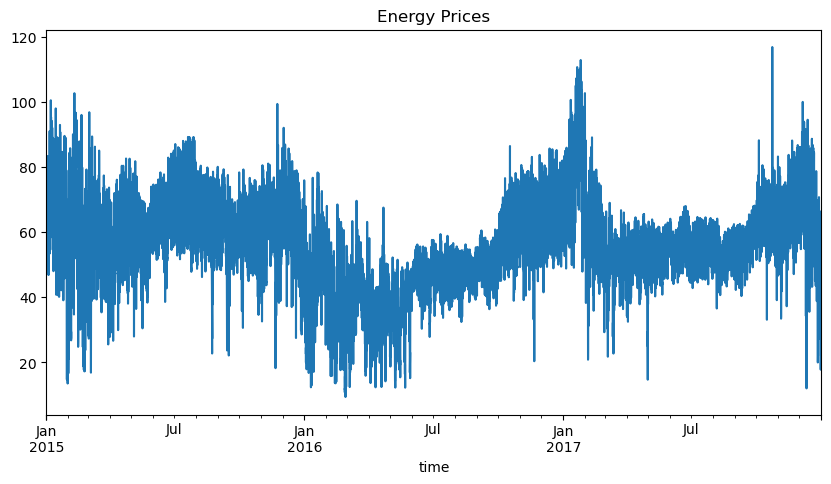

In [6]:
color_pal = sns.color_palette()
y_train.plot(#style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Energy Prices')
plt.show()

In [7]:
# Format data for prophet model using ds and y

# Rename the index
y_train.index.name = 'ds'

# Rename the Series itself
y_train.name = 'y'

# Optionally, convert to a DataFrame
df_y_price = y_train.reset_index()

In [8]:
#Removing timezones
df_y_price['ds'] = df_y_price['ds'].dt.tz_localize(None)

In [9]:
%%time
model = Prophet()
model.fit(df_y_price)

15:01:45 - cmdstanpy - INFO - Chain [1] start processing
15:02:05 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.2 s, sys: 319 ms, total: 3.51 s
Wall time: 25.4 s


In [10]:
y_test.index.name = 'ds'

# Rename the Series itself
y_test.name = 'y'

# Optionally, convert to a DataFrame
df_y_price_test = y_test.reset_index()

df_y_price_test['ds'] = df_y_price_test['ds'].dt.tz_localize(None)

In [11]:
price_forecast = model.predict(df_y_price_test)

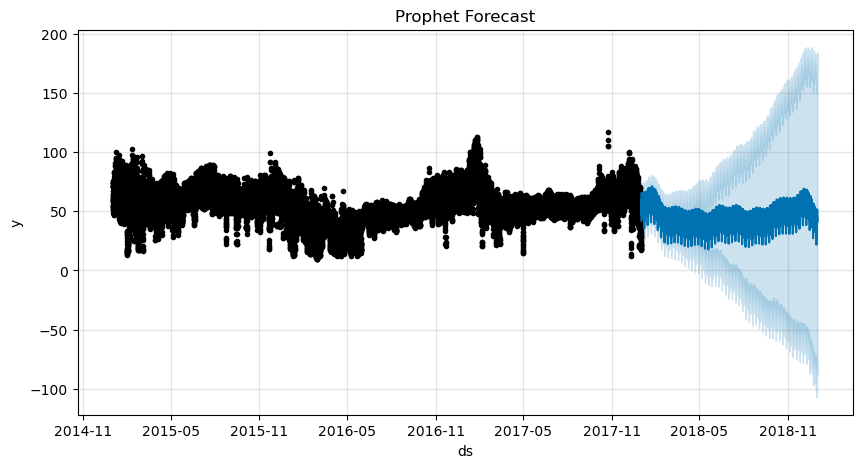

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(price_forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

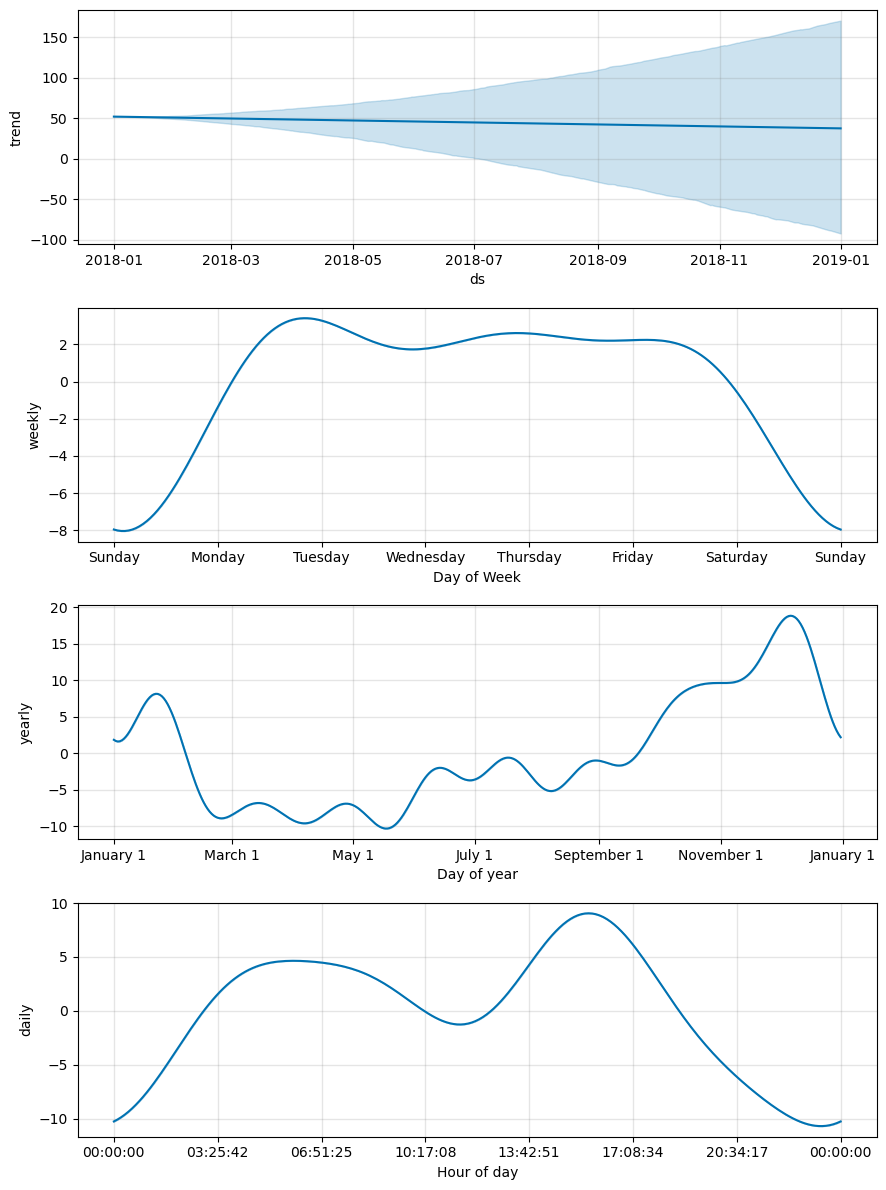

In [13]:
fig = model.plot_components(price_forecast)
plt.show()

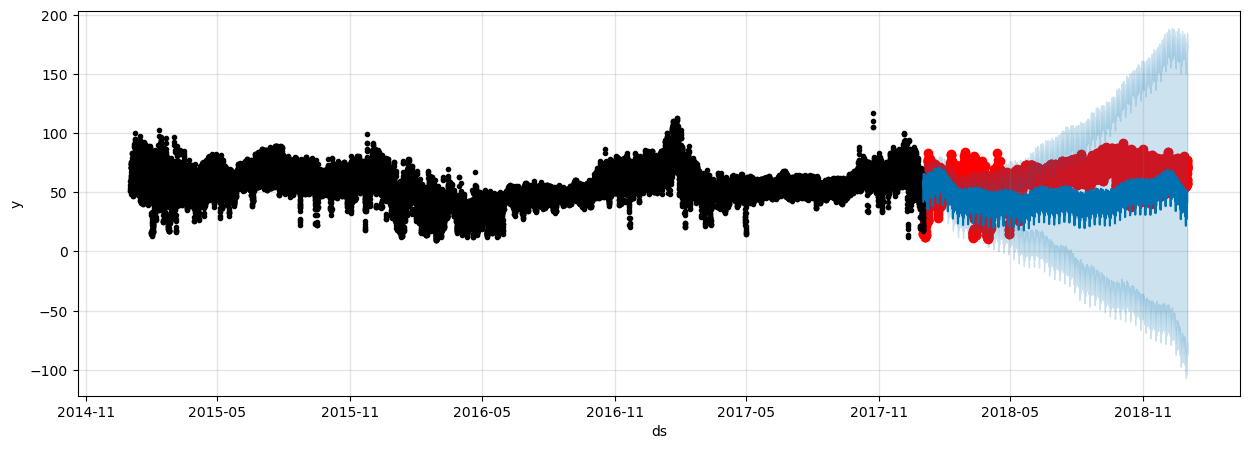

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(y_test.index, y_test, color='r')
fig = model.plot(price_forecast, ax=ax)

In [15]:
mse_prophet = mean_squared_error(y_true=df_y_price_test['y'], y_pred=price_forecast['yhat'])

print(f"Test MSE for Prophet: {mse_prophet}")

Test MSE for Prophet: 507.09425689360324


In [16]:
np.sqrt(mse_prophet)

22.518753448927924